# RNNs for Time Series Prediction


In this notebook, we will deploy a simple probabilistic model using a RNN to infer the probability distribution of a time-series.


In [1]:
import torch
from torch import nn
from torch import optim
import numpy as np
import time
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'  #To get figures with high quality!


## Create a synthetic database


We will generate $N$ target signals of length $T$ time steps. 

In [2]:
N = 1000 # Number of signals

T = 200

c = 0

phi_1 = 1

phi_2 = -1

phi_3 = 1

sigma = 1

X = np.zeros([N,T])

np.random.seed(23)

X[:,0] = c + np.random.randn(N,)*np.sqrt(sigma)

X[:,1] = c + phi_1 * X[:,0] + np.random.randn(N,)*np.sqrt(sigma)

X[:,2] = c + phi_1 * X[:,1] + phi_2 * X[:,0] + np.random.randn(N,)*np.sqrt(sigma)

X[:,3] = c + phi_1 * X[:,2] + phi_2 * X[:,1] + phi_3 * X[:,0] + np.random.randn(N,)*np.sqrt(sigma)

t = 4

while (t<T):

    X[:,t] = c + phi_1 * X[:,t-1] + phi_2 * X[:,t-2] + phi_3 * X[:,t-3] + np.random.randn(N,)*np.sqrt(sigma)
    
    t +=1
    

# Create targets

Y = X[:,1:] # all but the first
X = X[:,:-1] # all but the last piece of data

T -=1

In [3]:
X.shape == Y.shape

# we can see the the X and Y matrices have the same shape.

True

The goal of the RNN will be to predict the value of the signal in the next time point given the current observation. 
Lets plot one of the signals versus the *target*, which is the same signal but shifted to the right.

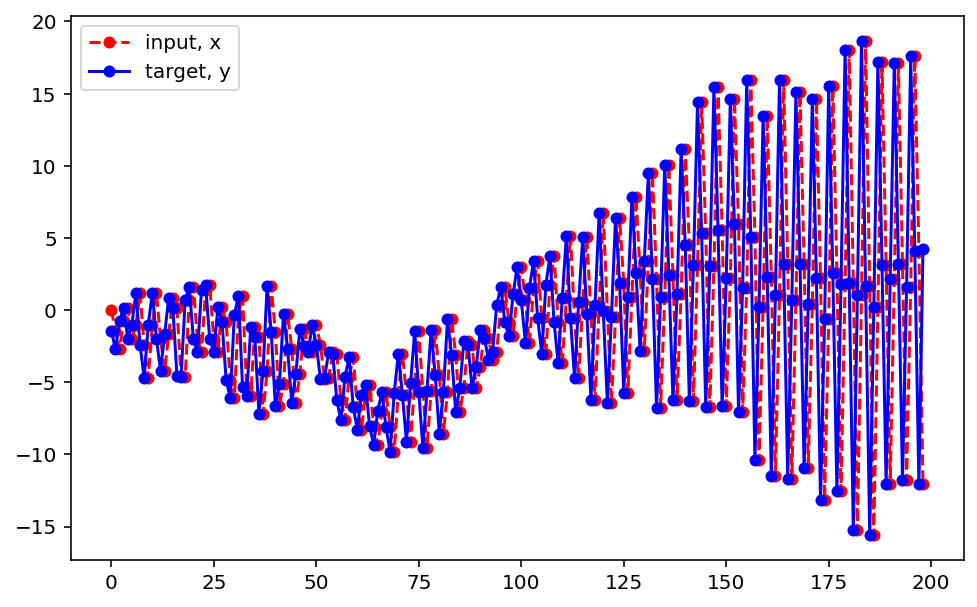

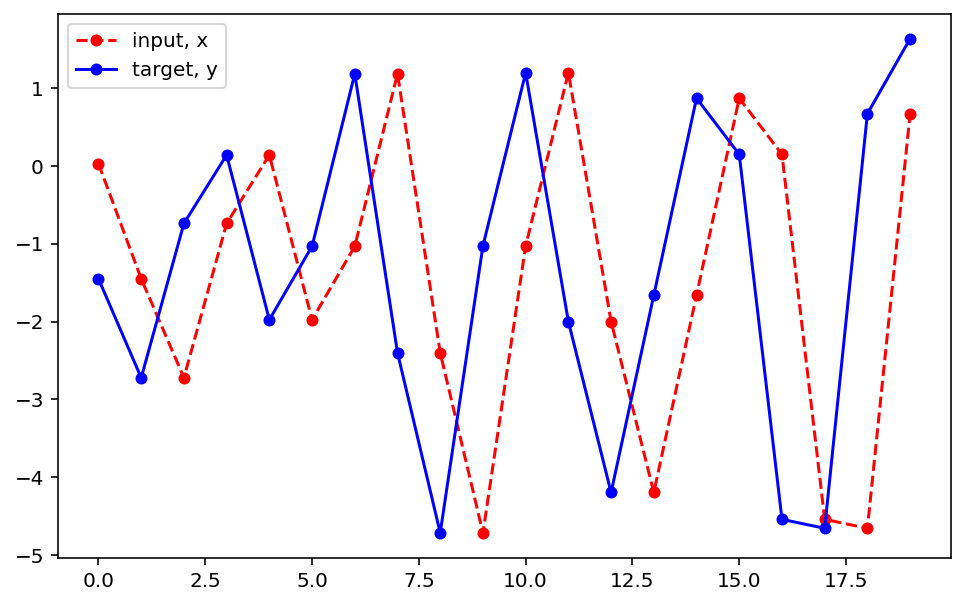

In [4]:
# Plot the signal 
plt.figure(figsize=(8,5))
plt.plot(np.arange(T), X[1,:T], 'r.--', label='input, x',ms=10) # x
plt.plot(np.arange(T), Y[1,:T], 'b.-', label='target, y',ms=10) # y

plt.legend(loc='best')

# Plot the signal (20 first steps)
plt.figure(figsize=(8,5))
plt.plot(np.arange(20), X[1,:20], 'r.--', label='input, x',ms=10) # x
plt.plot(np.arange(20), Y[1,:20], 'b.-', label='target, y',ms=10) # y

plt.legend(loc='best')

## Define RNN

Next, we define an RNN in PyTorch. We'll use `nn.RNN` to create an RNN layer, which takes in a number of parameters:
* **input_size** - the size of the input
* **hidden_dim** - the dimension of the RNN output and the hidden state
* **n_layers** - the number of layers that make up the RNN, typically 1-3; greater than 1 means that you'll create a **stacked RNN** 


We can learn more about **RNN** in the [RNN documentation](https://pytorch.org/docs/stable/nn.html#rnn)


In [5]:
class RNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers,sigma):
        
        # input size -> Dimension of the input signal
        # outpusize -> Dimension of the output signal
        # hidden_dim -> Dimension of the rnn state
        # n_layers -> If >1, we are using a stacked RNN
        
        super().__init__()
        
        self.hidden_dim = hidden_dim
        
        self.input_size = input_size
        
        self.sigma = sigma

        # define an RNN with specified parameters
        # batch_first=True means that the first dimension of the input will be the batch_size
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_dim, num_layers=n_layers, 
                          nonlinearity='relu',batch_first=True)
        
        # last, fully-connected layer
        self.fc1 = nn.Linear(hidden_dim,output_size) 

    def forward(self, x, h0=None):
        
        batch_size = x.size(0) # Number of signals N
        seq_length = x.size(1) # T
        
        # get RNN outputs
        # r_out is the sequence of states
        # hidden is just the last state (we will use it for forecasting)
        r_out, hidden = self.rnn(x, h0)
        
        # shape r_out to be (seq_length, hidden_dim) #UNDERSTANDING THIS POINT IS IMPORTANT!!
        # (seq_length, hidden_dim) es el shape porque cada hidden layer lo va guardando(la prediccion para cada instante t)      
        r_out = r_out.reshape(-1, self.hidden_dim) 
        
        output = self.fc1(r_out)
        
        noise = torch.randn_like(output)*sigma
        
        output += noise
        
        # reshape back to temporal structure
        output = output.reshape([-1,seq_length,1])
        
        return output, hidden


In [6]:
# instantiate the object RNN with the right parameters for the problem.

input_size = X.shape[0]
output_size = X.shape[1]

my_rnn = RNN(input_size = 1, output_size = output_size, hidden_dim = 32, n_layers = 1, sigma = 1)

In [8]:
class RNN_extended(RNN):
        
    def __init__(self, num_data_train, num_iter, sequence_length,
                 input_size, output_size, hidden_dim, n_layers, sigma, lr=0.001):
        
        super().__init__(input_size, output_size, hidden_dim, n_layers,sigma) 
        
        self.hidden_dim = hidden_dim
        
        self.sequence_length = sequence_length
        
        self.num_layers = n_layers
        
        self.lr = lr #Learning Rate
        
        self.num_train = num_data_train #Number of training signals
        
        self.optim = optim.Adam(self.parameters(), self.lr)
        
        self.num_iter = num_iter
        
        self.criterion = nn.MSELoss()
        
        # A list to store the loss evolution along training
        
        self.loss_during_training = [] 
        
           
    def trainloop(self,x,y):
        
        # SGD Loop
        
        for e in range(int(self.num_iter)):
        
            self.optim.zero_grad() 
                
            x = torch.Tensor(x).view([self.num_train, self.sequence_length, 1])  

            y = torch.Tensor(y).view([self.num_train, self.sequence_length, 1])   

            out,hid = self.forward(x)
                
            loss = self.criterion(out,y) 
            
            loss.backward()
            
            # This code helps to avoid vanishing exploiting gradients in RNNs
            # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
            nn.utils.clip_grad_norm_(self.parameters(), 2.0)
                
            self.optim.step()
                
            self.loss_during_training.append(loss.item()/self.num_iter)

            if(e % 10 == 0): # Every 10 iterations

                print("Iteration %d. Training loss: %f" %(e,self.loss_during_training[-1]))                

In [9]:
T_train = 100

my_rnn = RNN_extended(num_data_train = X.shape[0], num_iter = 100, sequence_length = T_train,
                     input_size = 1, output_size = 1, hidden_dim = 32, n_layers = 1, sigma = 1.0, lr = 0.005)


In [10]:
my_rnn.trainloop(X[:,:T_train],Y[:,:T_train])

Iteration 0. Training loss: 0.137353
Iteration 10. Training loss: 0.099363
Iteration 20. Training loss: 0.062952
Iteration 30. Training loss: 0.022818
Iteration 40. Training loss: 0.019703
Iteration 50. Training loss: 0.013341
Iteration 60. Training loss: 0.011674
Iteration 70. Training loss: 0.011194
Iteration 80. Training loss: 0.010555
Iteration 90. Training loss: 0.010389
Iteration 100. Training loss: 0.010327
Iteration 110. Training loss: 0.010264
Iteration 120. Training loss: 0.010258
Iteration 130. Training loss: 0.010318
Iteration 140. Training loss: 0.010223
Iteration 150. Training loss: 0.010145
Iteration 160. Training loss: 0.010126
Iteration 170. Training loss: 0.010200
Iteration 180. Training loss: 0.010136
Iteration 190. Training loss: 0.010224


In [11]:
# plot of loss during training

train_loss = my_rnn.loss_during_training
print(train_loss.index(max(train_loss)))

# At the 17th value we get a peak.

17


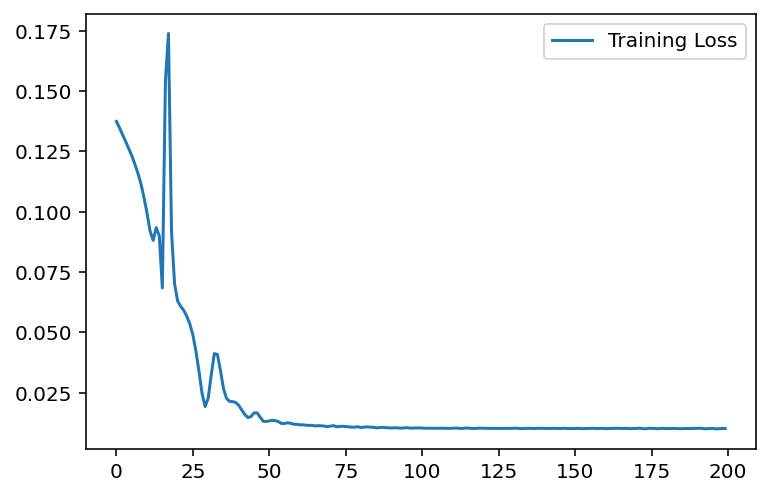

In [12]:
plt.plot(train_loss,label='Training Loss')
#plt.axhline(train_loss.index(max(train_loss)), c = 'green')
plt.legend()

# we can see that there are two 'peaks', at 17 and 29.

We can see that the loss starts to go down, but at a certain point, when we reach 30 iterations, the model starts to work in a non-standard way. After 50, however, the training loss starts to decrease considerably.

In [13]:
signal = 2


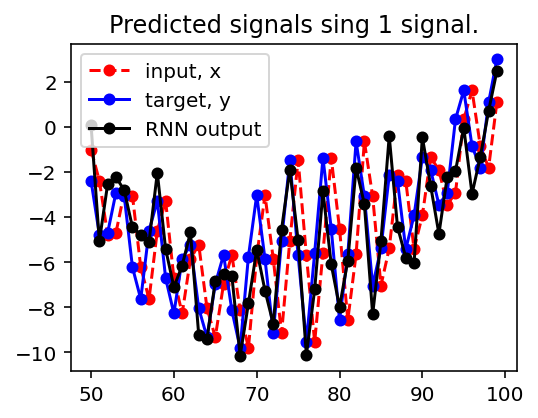

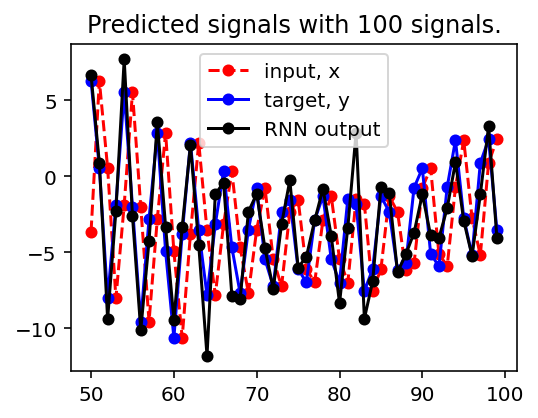

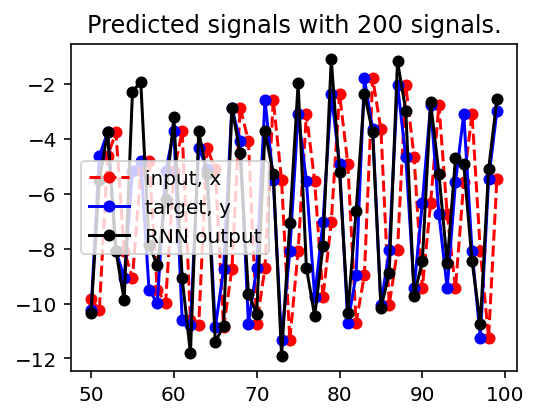

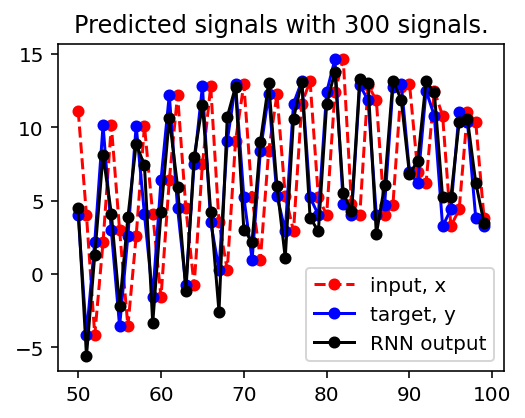

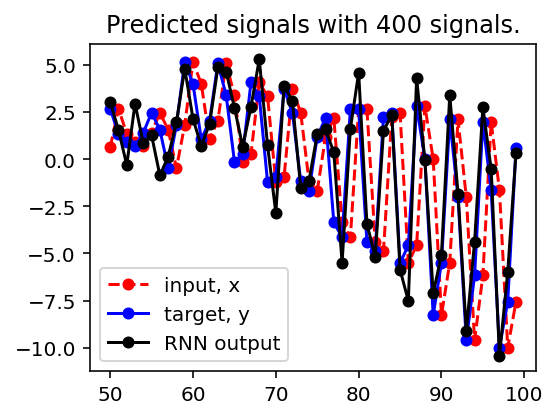

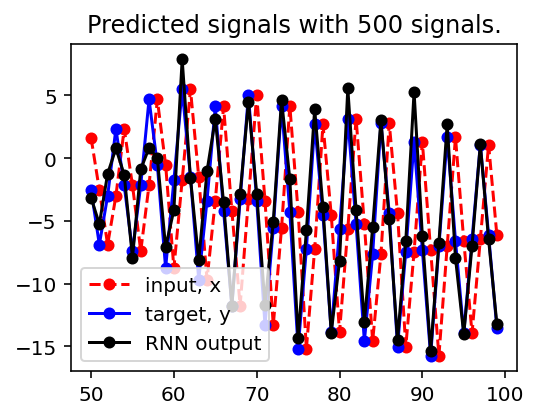

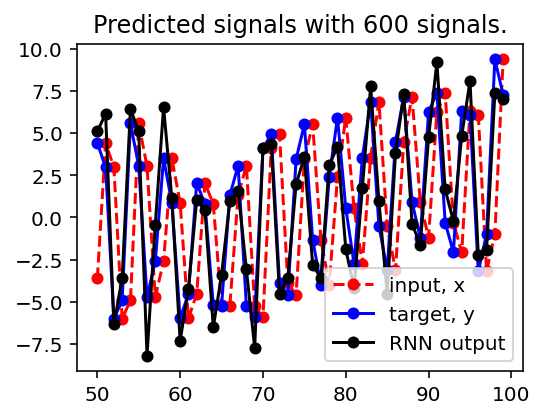

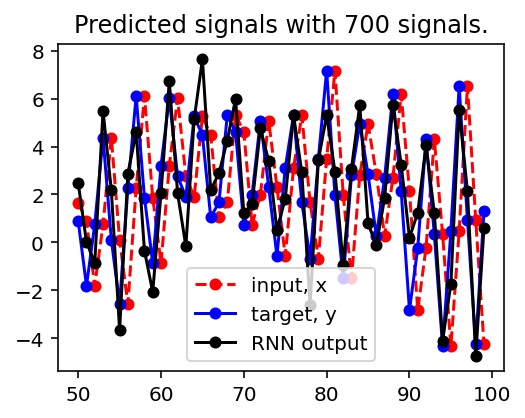

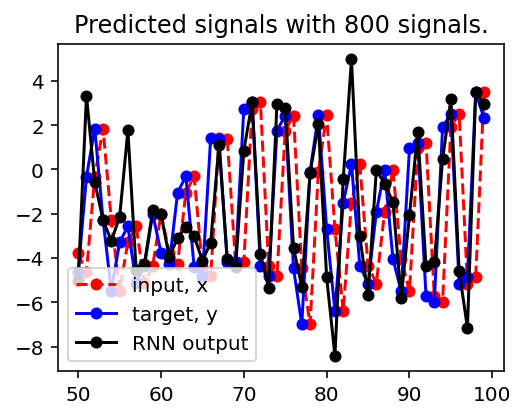

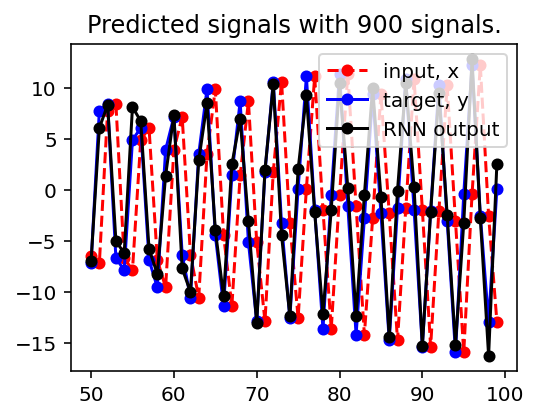

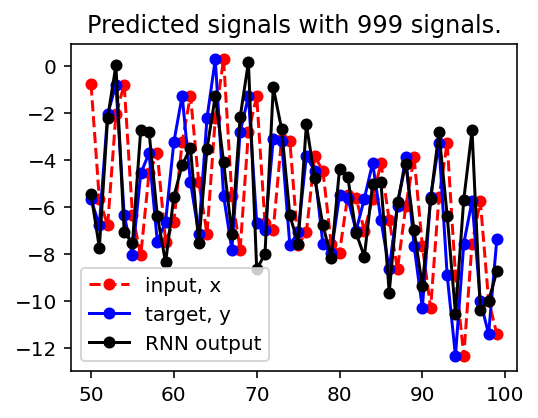

In [14]:
# We first evaluate the model for the N signals up to time T_train = 100

X_in = torch.Tensor(X[:,:T_train]).view(-1,T_train,1) 

o,h = my_rnn.forward(X_in) 

output_rnn = o.detach().numpy().reshape([N,-1])

offset = 50

signals = list(range(1, N+100, 100))
signals[-1] = N

for signal in signals:
  signal = (signal-1 if signal > 1 else signal)
  # Plot the first training signal and the target
  plt.figure(figsize=(4,3))
  plt.plot(np.arange(T_train-offset,T_train,1), X[signal,T_train-offset:T_train], 'r.--', label='input, x',ms=10) # x
  plt.plot(np.arange(T_train-offset,T_train,1), Y[signal,T_train-offset:T_train], 'b.-', label='target, y',ms=10) # x
  plt.plot(np.arange(T_train-offset,T_train,1), output_rnn[signal,T_train-offset:T_train], 'k.-', label='RNN output',ms=10) # y
  plt.title(f'Predicted signals with {signal} signals.' if signal > 1 else 'Predicted signals sing 1 signal.')
  plt.legend(loc='best')

It is clear to see that we get very good results for the different signals!

The RNN model have clearly learnt the dynamics of the dataset due to the fact that we have used the full signal $D$ to compute the sequence of states. From now on, we will focus on **forecasting**, i.e: feeding the RNN the output that we predicted and doing so recursively for as long as we want.

To do forecasting, we have to recursively call the `forward` method and feed the obtained RNN output and state as the entry and initial state for the next `forward` call. The following code would do the job:

Between t=0 and t=100, we feed the real values
From t=100, we feed the estimated values (forecasting)


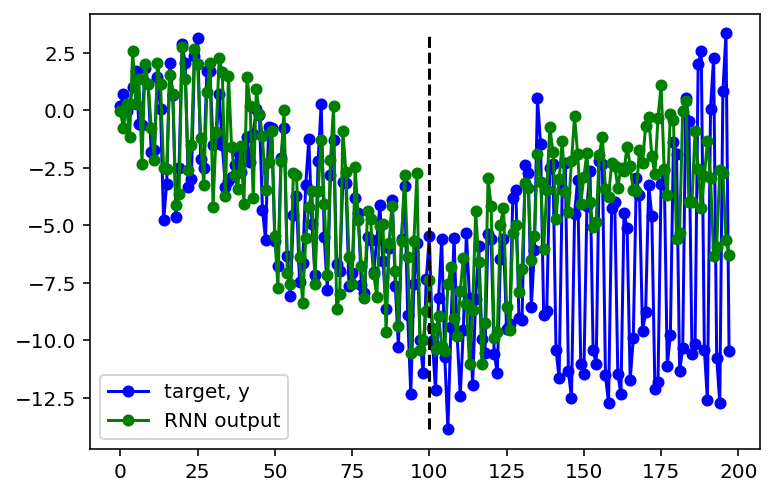

In [15]:
# We take the last RNN output 
current_input = o[:,-1,:].view([N,1,1]) #Note that current input only contains one observation for each of the N signals
# We take the last RNN state
current_state = h

forecast_rnn = np.zeros([N,T-T_train])

for t in range(T-T_train):
    
    # ... and feed them as input and initial state
    
    current_input,current_state = my_rnn.forward(current_input,current_state)
    
    forecast_rnn[:,t] = current_input.detach().numpy().reshape([-1,])
    
final_rnn_reconstruct = np.hstack([output_rnn,forecast_rnn])

# We plot the signal and the target before and after forecasting

plt.plot(np.arange(0,T-1,1), Y[signal,:-1].reshape([-1]), 'b.-', label='target, y',ms=10) 
plt.plot(np.arange(0,T-1,1), final_rnn_reconstruct[signal,:-1], 'g.-', label='RNN output',ms=10) 
plt.plot([T_train,T_train],[np.min(Y[signal,:]),np.max(Y[signal,:])],'k--')
plt.legend()

print('Between t=0 and t=100, we feed the real values')
print('From t=100, we feed the estimated values (forecasting)')

It can be noted that during **forecasting**, sometimes the model quickly diverges from the target. That is *expected* as we are sampling from the generative model and it is likely that do not get exactly the same sample! Particularly in RNN, since they have short memory. It is clear to see that **forecasting** does not yield the best results!

## LSTMs

Lets see how an LSTM would perform in this context. We can look at the documentation [LSTM layer](https://pytorch.org/docs/stable/nn.html#lstm) to find more information.

In [16]:
# input_size is the number of characters this cell expects to see as sequential input, 
# n_hidden is the number of units in the hidden layers in the cell.


class LSTM(nn.Module):
    
    def __init__(self, input_size, output_size, hidden_dim, n_layers, sigma, drop_prob):
        
        
        super().__init__()
        
        self.hidden_dim = hidden_dim
        
        self.input_size = input_size
        
        self.sigma = sigma
        
        self.lstm = nn.LSTM(input_size, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)
        
        self.fc1 = nn.Linear(hidden_dim, output_size) # it cannot be the input size!

    def forward(self, x, h0=None, valid=False):
        
        # If we use stacked LSTMs, we have to control the evaluation mode due to the dropout between LSTMs
        if(valid):
            self.eval()
        else:
            self.train()
        
        batch_size = x.size(0) # Number of signals N
        seq_length = x.size(1) # T
        
        # get RNN outputs
        # r_out is the sequence of states
        # hidden is just the last state (we will use it for forecasting)
    
        r_out, hidden = self.lstm(x, h0)
        
        # shape r_out to be (seq_length, hidden_dim)    
        r_out = r_out.reshape(-1, self.hidden_dim) 
        
        output = self.fc1(r_out)
        
        noise = torch.randn_like(output)*sigma
        
        output += noise
        
        # reshape back to temporal structure
        output = output.reshape([-1,seq_length,1])
        
        return output, hidden


In [17]:
class LSTM_extended(LSTM):
        
    def __init__(self, num_data_train, num_iter, sequence_length,
                 input_size, output_size, hidden_dim, n_layers, sigma, drop_prob=0.3, lr=0.001):
        
        super().__init__(input_size, output_size, hidden_dim, n_layers,sigma,drop_prob) 
        
        self.hidden_dim = hidden_dim
        
        self.sequence_length = sequence_length
        
        self.num_layers = n_layers
        
        self.lr = lr #Learning Rate
        
        self.num_train = num_data_train #Number of training signals
        
        self.optim = optim.Adam(self.parameters(), self.lr)
        
        self.num_iter = num_iter
        
        self.criterion = nn.MSELoss() # we use the Average loss once again.
        
        # A list to store the loss evolution along training
        
        self.loss_during_training = [] 
        
           
    def trainloop(self,x,y):
        
        # SGD Loop
        
        for e in range(int(self.num_iter)):
        
            self.optim.zero_grad() 
                
            x = torch.Tensor(x).view([self.num_train, self.sequence_length, 1]) 

            y = torch.Tensor(y).view([self.num_train, self.sequence_length, 1])

            out,hid = self.forward(x)
                
            loss = self.criterion(out,y) 
            
            loss.backward()
            
            # This code helps to avoid vanishing exploiting gradients in RNNs
            # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
            nn.utils.clip_grad_norm_(self.parameters(), 2.0)
                
            self.optim.step()
                
            self.loss_during_training.append(loss.item()/self.num_iter)

            if(e % 10 == 0): # Every 10 iterations

                print("Iteration %d. Training loss: %f" %(e,self.loss_during_training[-1]))                

In [18]:
T_train = 100

# train the LSTM

my_LSTM = LSTM_extended(num_data_train = X.shape[0], num_iter = 200, sequence_length = T_train,
                     input_size = 1, output_size = 1, hidden_dim = 32, n_layers = 1, sigma = 1.0, lr = 0.01)

# we can see we get the mentioned warning.

my_LSTM.trainloop(X[:,:T_train],Y[:,:T_train])

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:63: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Iteration 0. Training loss: 0.139033
Iteration 10. Training loss: 0.106556
Iteration 20. Training loss: 0.092498
Iteration 30. Training loss: 0.072700
Iteration 40. Training loss: 0.044334
Iteration 50. Training loss: 0.027577
Iteration 60. Training loss: 0.018203
Iteration 70. Training loss: 0.014195
Iteration 80. Training loss: 0.012741
Iteration 90. Training loss: 0.012388
Iteration 100. Training loss: 0.012101
Iteration 110. Training loss: 0.011620
Iteration 120. Training loss: 0.011310
Iteration 130. Training loss: 0.011049
Iteration 140. Training loss: 0.010937
Iteration 150. Training loss: 0.010900
Iteration 160. Training loss: 0.010961
Iteration 170. Training loss: 0.010945
Iteration 180. Training loss: 0.010597
Iteration 190. Training loss: 0.010453


> Plot of the loss function along training


Text(0.5, 1.0, 'Loss during Training of LTSM model')

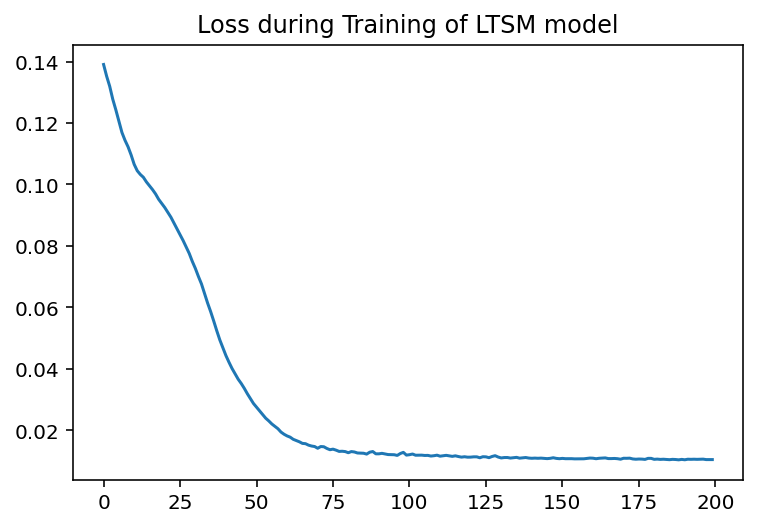

In [19]:
plt.plot(my_LSTM.loss_during_training)
plt.title('Loss during Training of LTSM model')

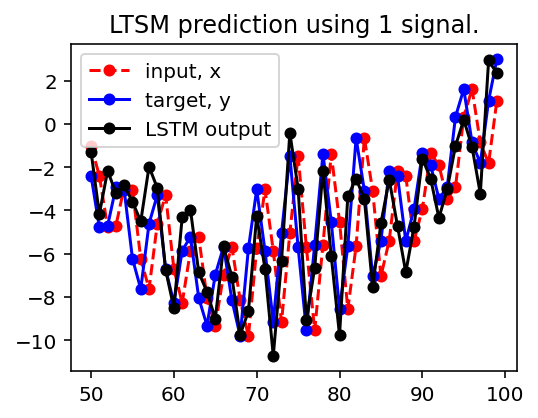

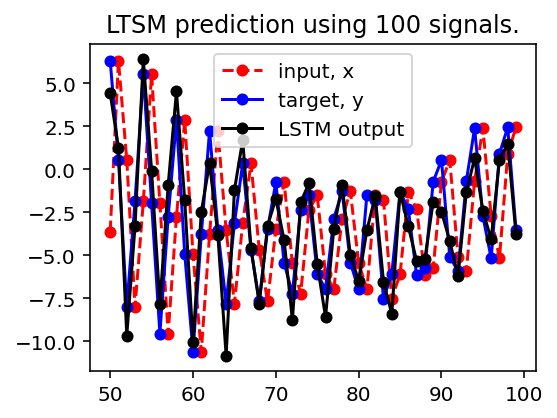

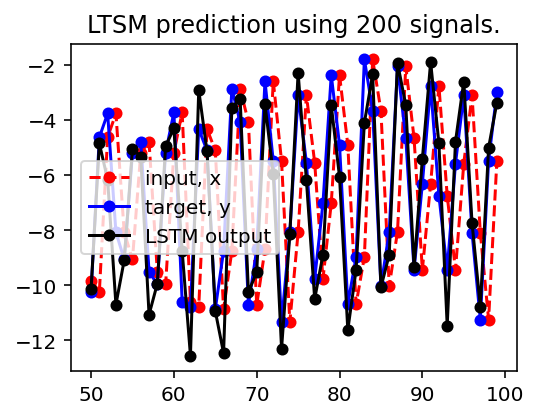

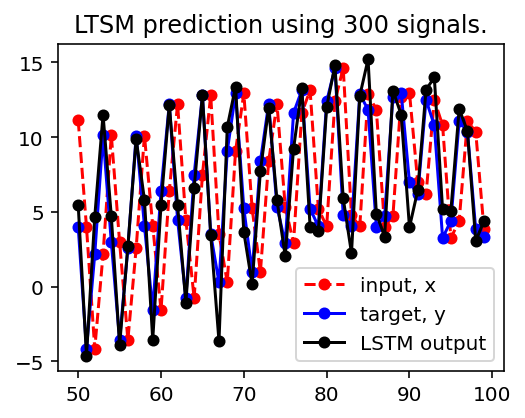

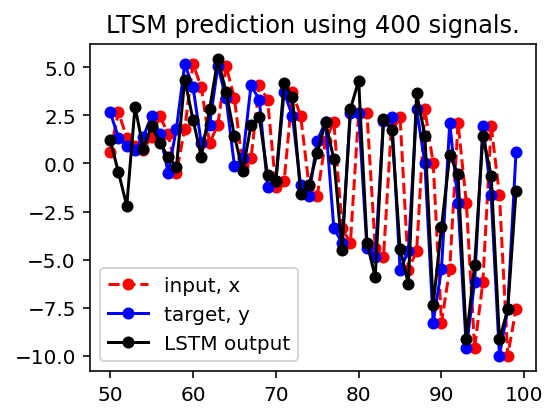

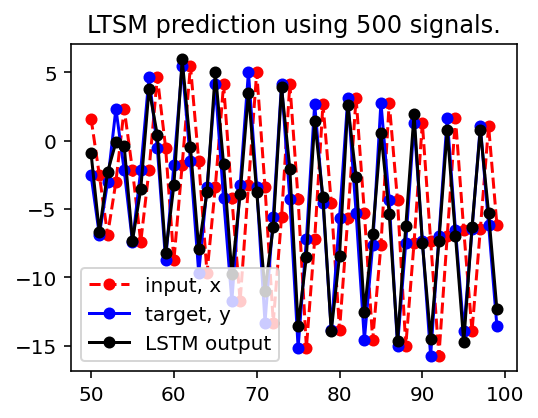

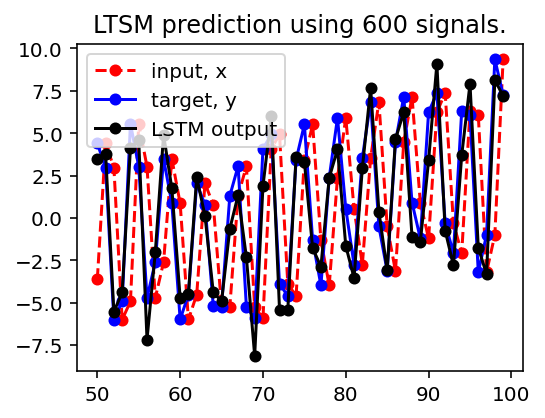

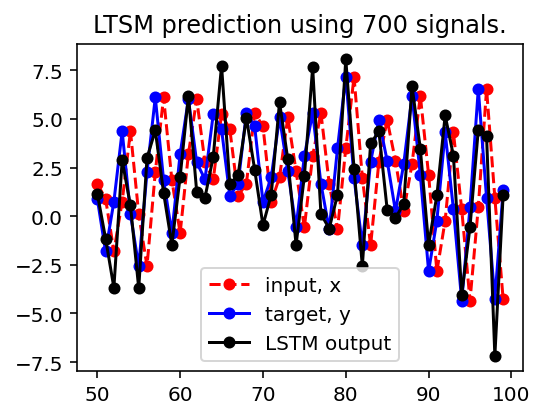

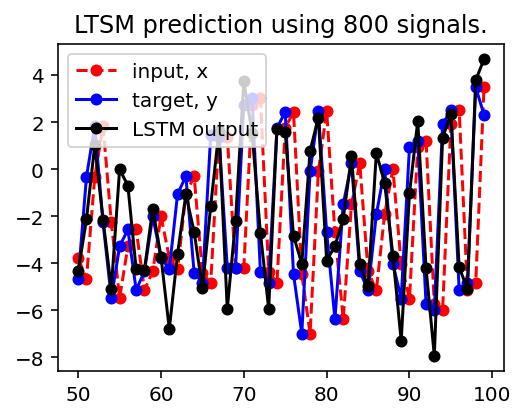

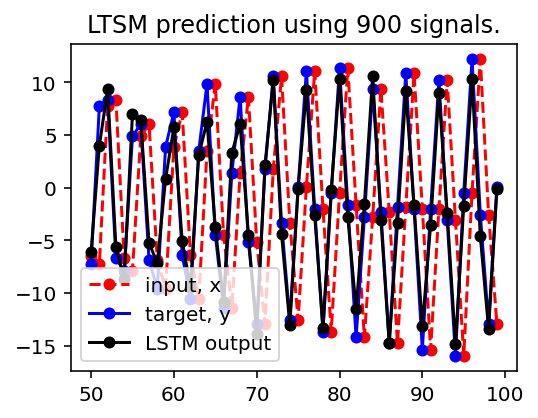

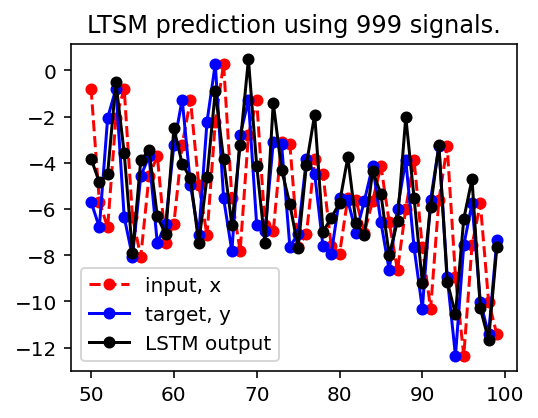

In [20]:
# We first evaluate the model for the N signals up to time T_train = 100
X_in = torch.Tensor(X[:,:T_train]).view(-1,T_train,1) # YOUR CODE HERE

o,h = my_LSTM.forward(X_in) # YOUR CODE HERE

output_lstm = o.detach().numpy().reshape([N,-1])

offset = 50

signals = list(range(1, N+100, 100))
signals[-1] = N

for signal in signals:
  signal = (signal-1 if signal > 1 else signal)
  # Plot the first training signal and the target
  plt.figure(figsize=(4,3))
  plt.plot(np.arange(T_train-offset,T_train,1), X[signal,T_train-offset:T_train], 'r.--', label='input, x',ms=10) # x
  plt.plot(np.arange(T_train-offset,T_train,1), Y[signal,T_train-offset:T_train], 'b.-', label='target, y',ms=10) # x
  plt.plot(np.arange(T_train-offset,T_train,1), output_lstm[signal,T_train-offset:T_train], 'k.-', label='LSTM output',ms=10) # y
  plt.title(f'LTSM prediction using {signal} signals.' if signal > 1 else 'LTSM prediction using 1 signal.')
  plt.legend(loc='best')

Once again, it is clear to see that the results are good

Between t=0 and t=100, we feed the real values
From t=100, we feed the estimated values (forecasting)


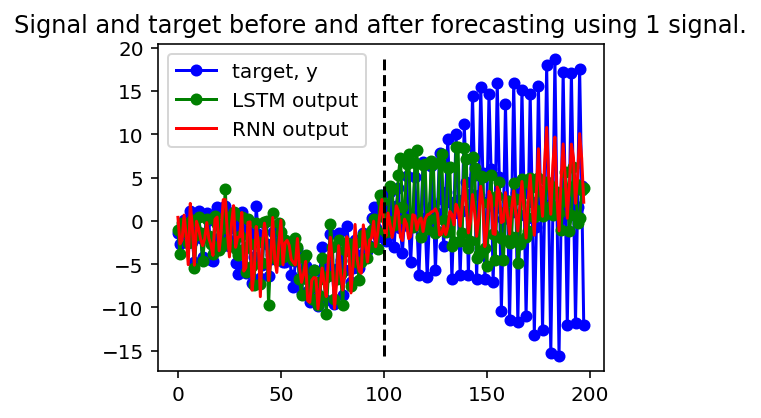

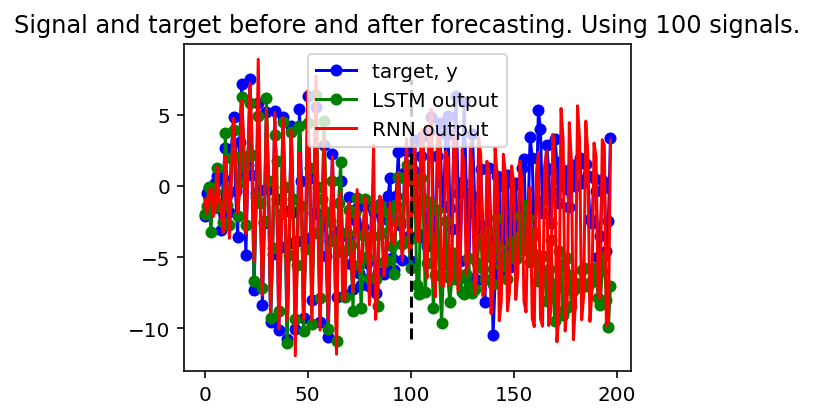

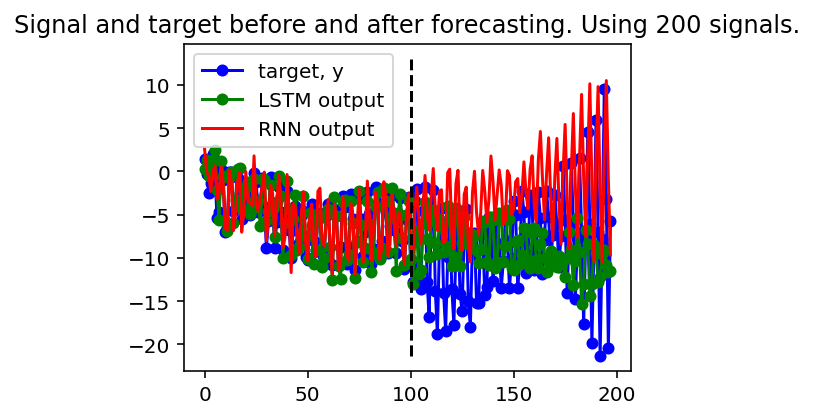

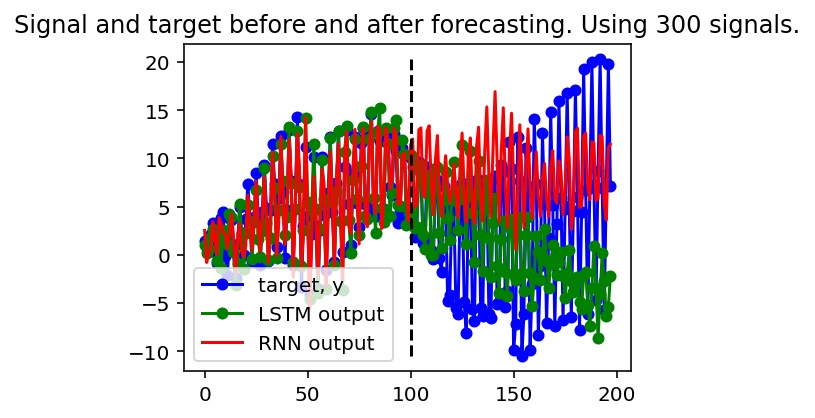

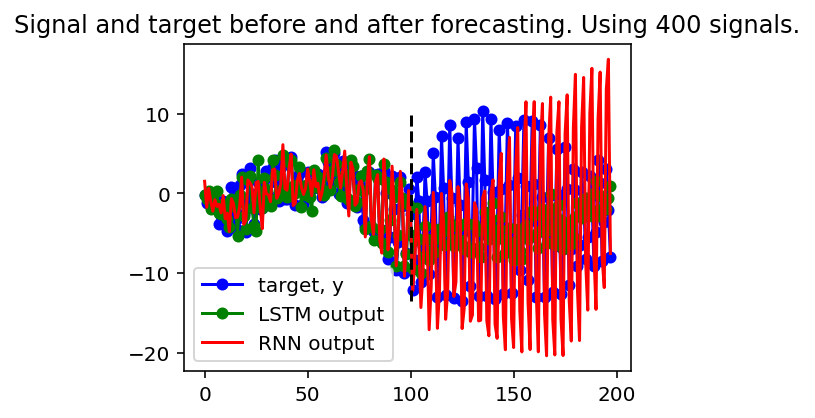

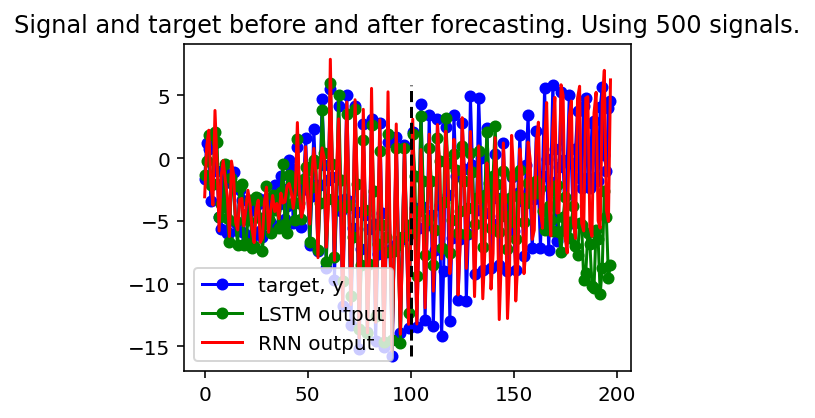

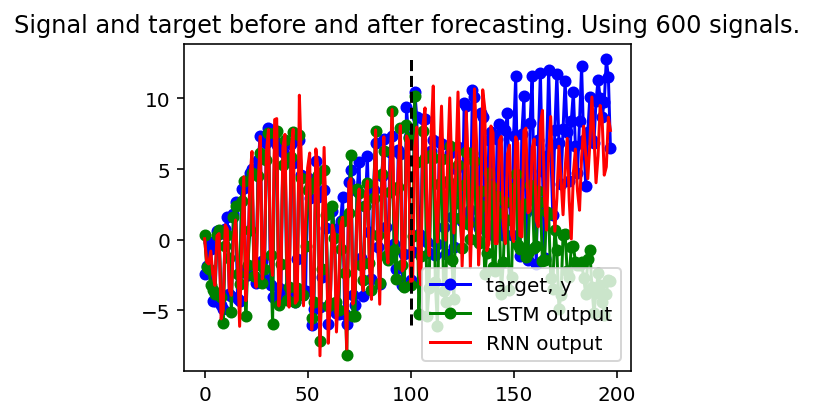

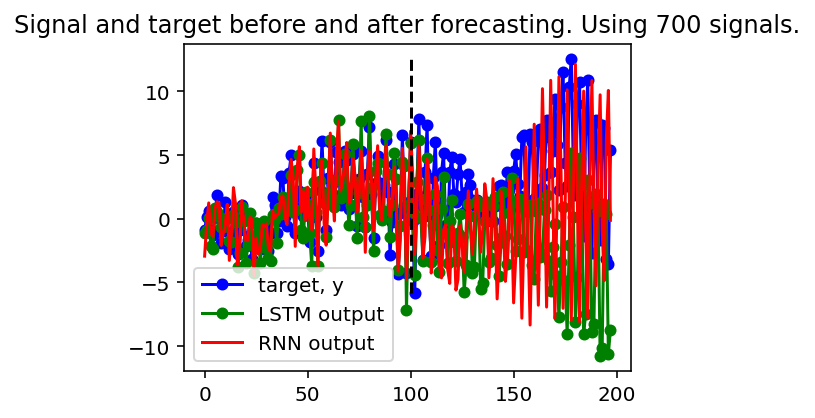

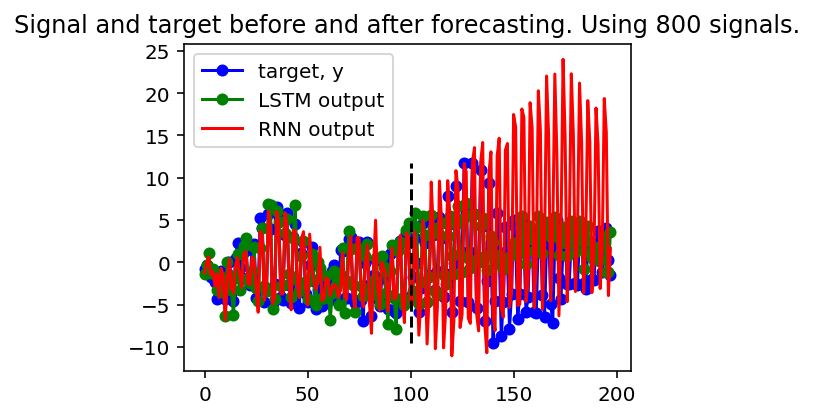

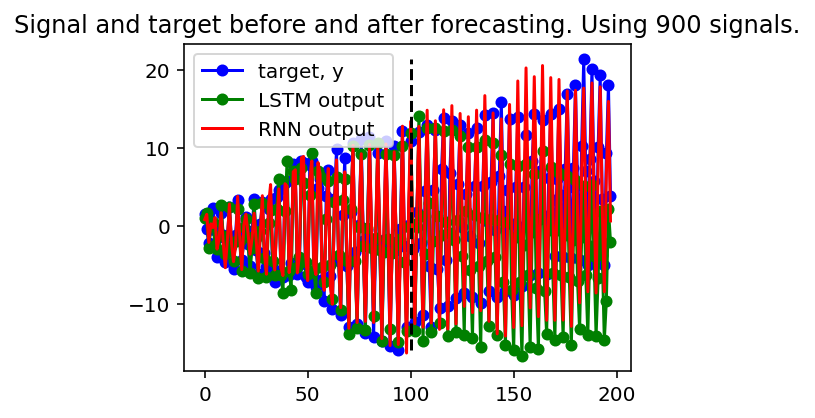

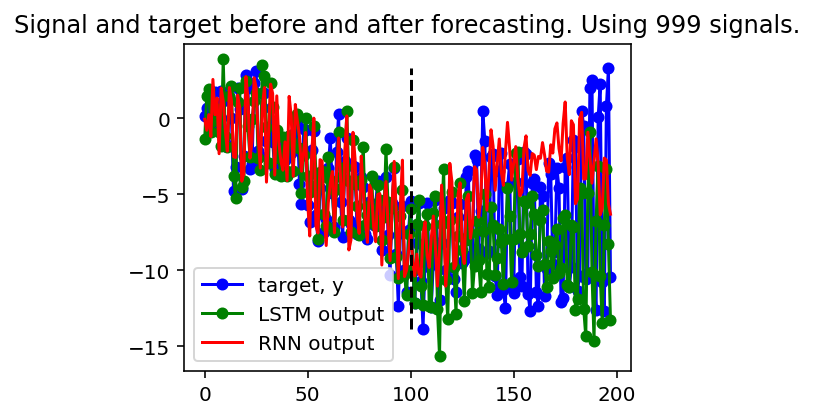

In [21]:
# We take the last RNN output 
current_input = o[:,-1,:].view([N,1,1]) #Note that current input only contains one observation for each of the N signals
# We take the last RNN state
current_state = h

forecast_lstm = np.zeros([N,T-T_train])

for t in range(T-T_train):
    
    # ... and feed them as input and initial state
    
    current_input, current_state = my_LSTM.forward(current_input, current_state)# YOUR CODE HERE
    
    forecast_lstm[:,t] = current_input.detach().numpy().reshape([-1,])
    
final_lstm_reconstruct = np.hstack([output_lstm,forecast_lstm])

# We plot the signal and the target before and after forecasting

signals = list(range(1, N+100, 100))
signals[-1] = N

for signal in signals:
  signal = (signal-1 if signal > 1 else signal)
  # Plot the first training signal and the target
  plt.figure(figsize=(4,3))
  plt.plot(np.arange(0,T-1,1), Y[signal,:-1].reshape([-1]), 'b.-', label='target, y',ms=10)   
  plt.plot(np.arange(0,T-1,1), final_lstm_reconstruct[signal,:-1], 'g.-', label='LSTM output',ms=10) 
  plt.plot(np.arange(0,T-1,1), final_rnn_reconstruct[signal,:-1], 'r-', label='RNN output',ms=10) 
  plt.plot([T_train,T_train],[np.min(Y[signal,:]),np.max(Y[signal,:])],'k--')
  plt.title(f'Signal and target before and after forecasting. Using {signal} signals.' if signal > 1 else 'Signal and target before and after forecasting using 1 signal.')
  plt.legend(loc='best')

plt.legend()

print('Between t=0 and t=100, we feed the real values')
print('From t=100, we feed the estimated values (forecasting)')

We observe that the **LSTM** is able to keep track of the real signal during forecasting for a longer period of time.

> Train an LSTM with 3 layers and evaluate the model.

In [22]:
# this is just the same code we used before, but the n_layers parameter now is 3.
T_train = 100

my_LSTM2 = LSTM_extended(num_data_train = X.shape[0], num_iter = 200, sequence_length = T_train,
                     input_size = 1, output_size = 1, hidden_dim = 32, n_layers = 3, sigma = 1.0, lr = 0.005)

my_LSTM2.trainloop(X[:,:T_train],Y[:,:T_train])

Iteration 0. Training loss: 0.137094
Iteration 10. Training loss: 0.104048
Iteration 20. Training loss: 0.092539
Iteration 30. Training loss: 0.084960
Iteration 40. Training loss: 0.079591
Iteration 50. Training loss: 0.073103
Iteration 60. Training loss: 0.048939
Iteration 70. Training loss: 0.035287
Iteration 80. Training loss: 0.027416
Iteration 90. Training loss: 0.023341
Iteration 100. Training loss: 0.021046
Iteration 110. Training loss: 0.019145
Iteration 120. Training loss: 0.018147
Iteration 130. Training loss: 0.017386
Iteration 140. Training loss: 0.016709
Iteration 150. Training loss: 0.016091
Iteration 160. Training loss: 0.015719
Iteration 170. Training loss: 0.015586
Iteration 180. Training loss: 0.015204
Iteration 190. Training loss: 0.015082


We can see that the time to train is now longer.

In [23]:
signals = list(range(1, N+100, 100))
signals[-1] = N-1
signals

[1, 101, 201, 301, 401, 501, 601, 701, 801, 901, 999]

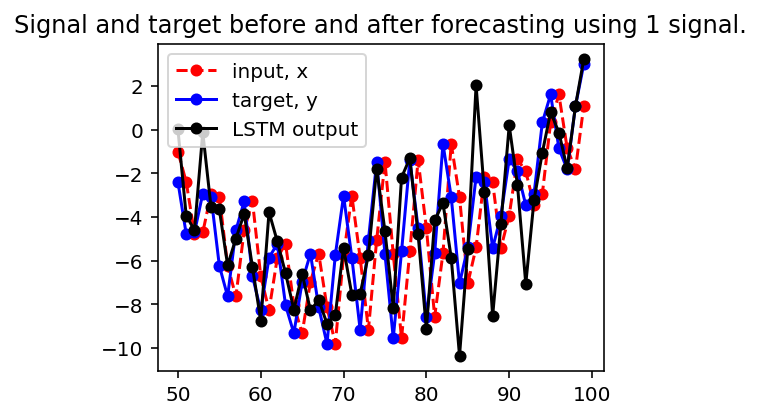

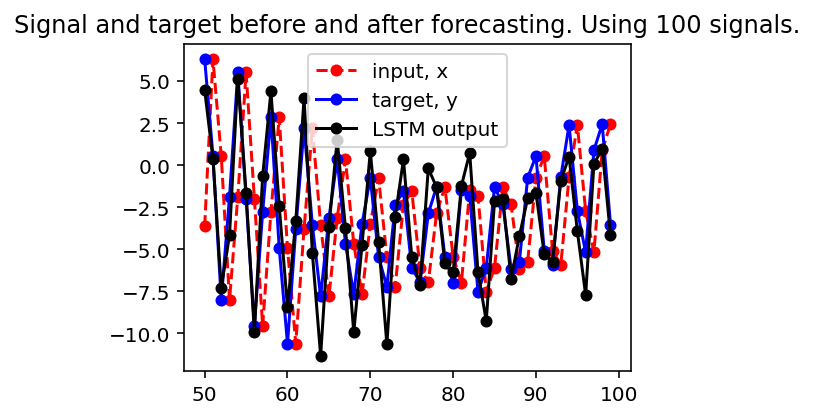

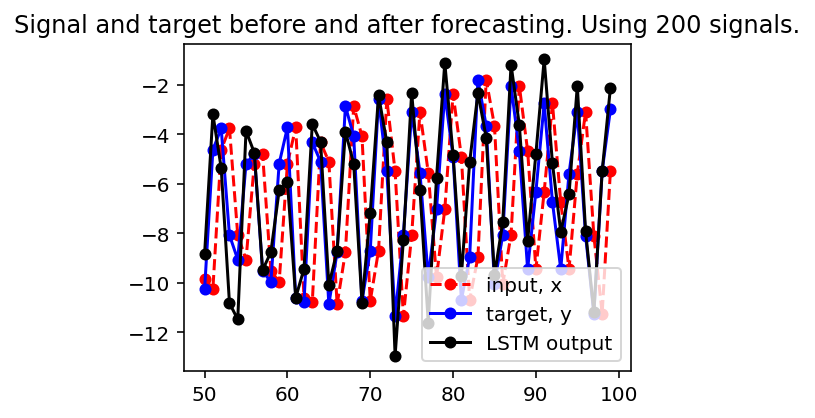

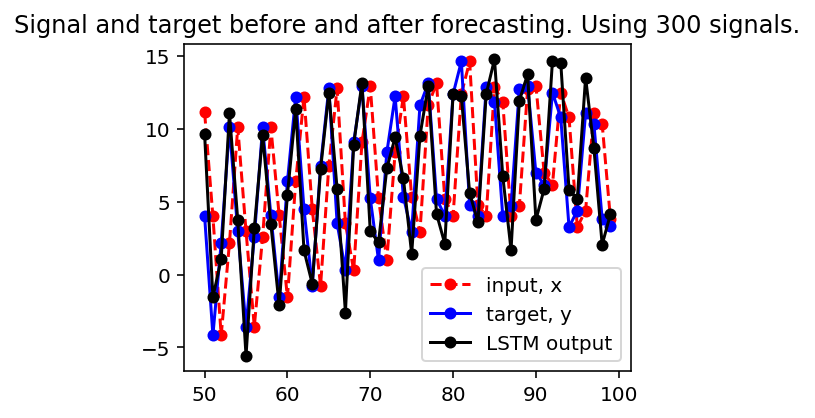

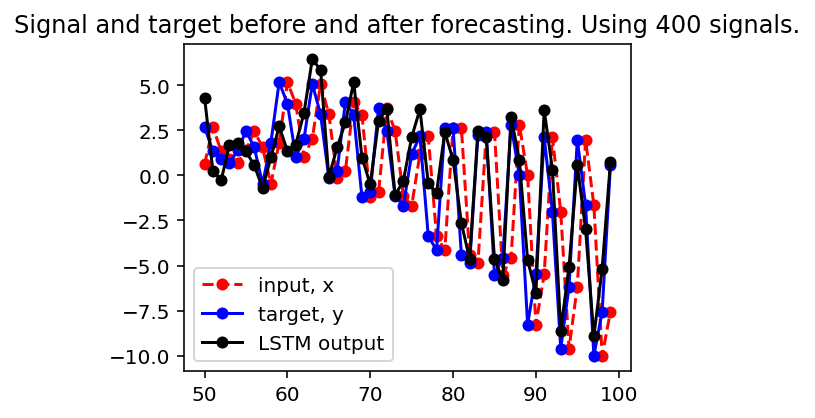

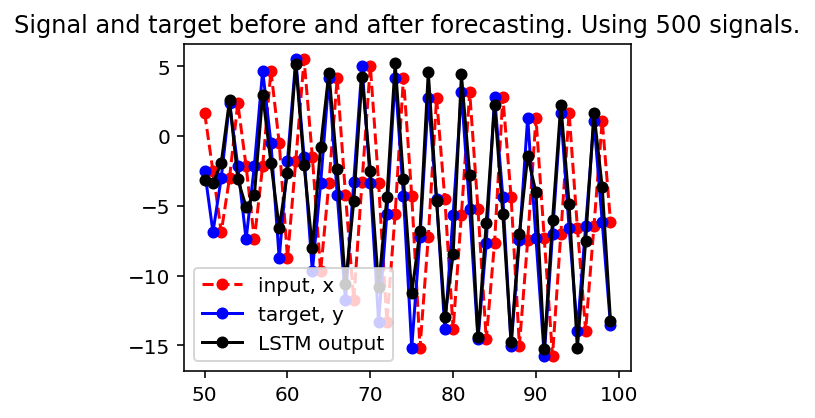

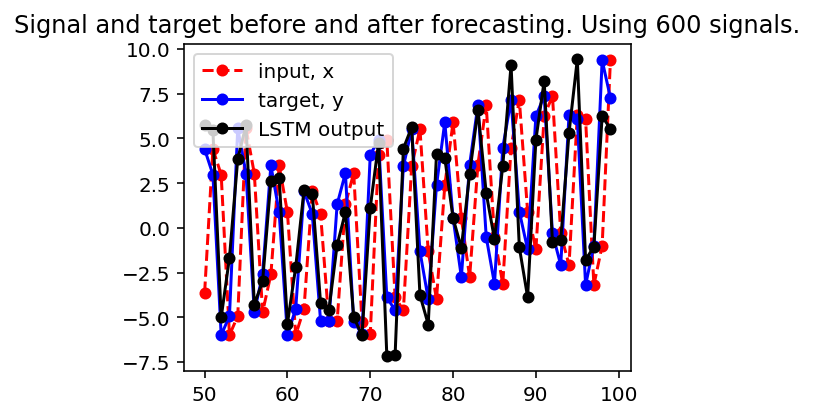

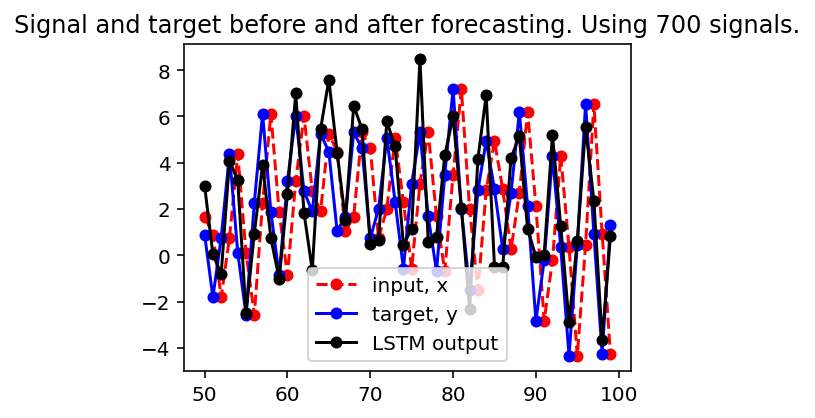

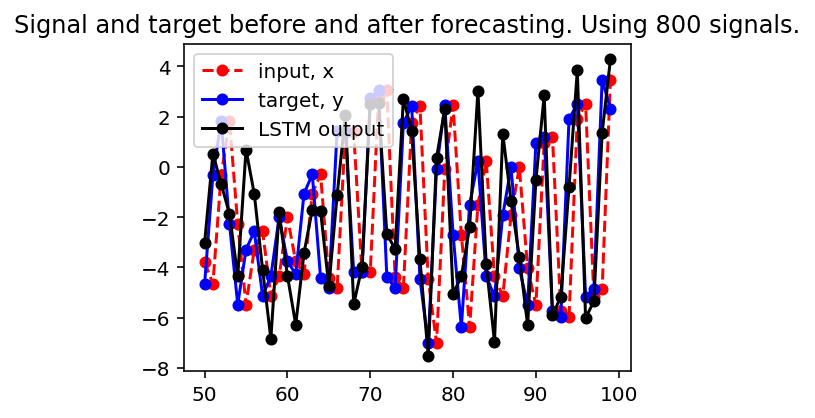

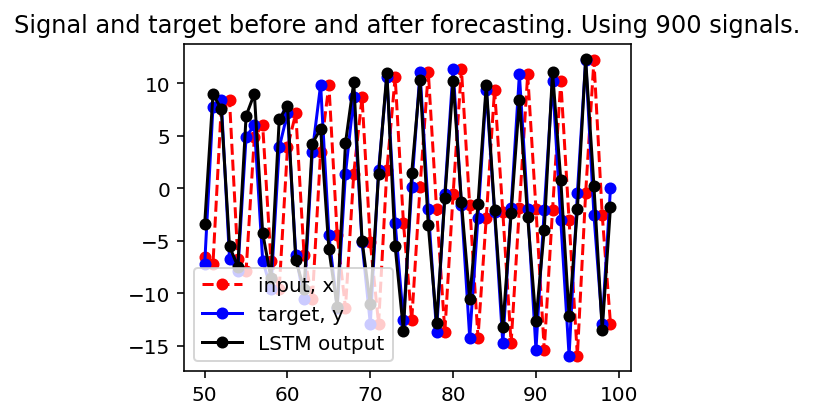

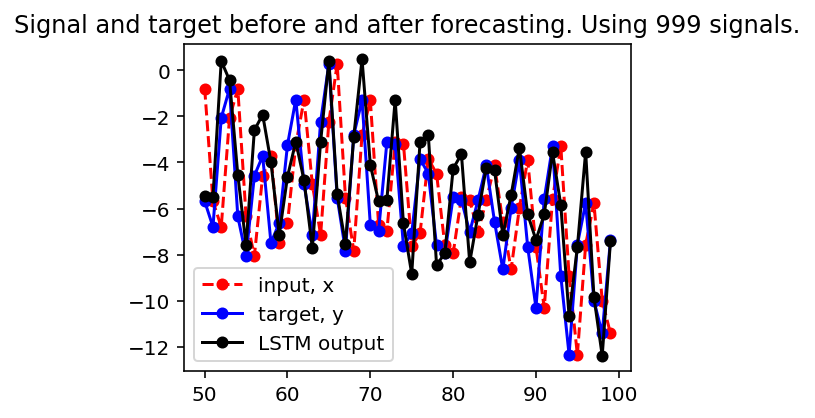

In [24]:
################# EVALUATION

# We first evaluate the model for the N signals up to time T_train = 100
X_in = torch.Tensor(X[:,:T_train]).view(-1,T_train,1) 

o,h = my_LSTM2.forward(X_in) 

output_lstm = o.detach().numpy().reshape([N,-1])

offset = 50

signals = list(range(1, N+100, 100))
signals[-1] = N


for signal in signals:
  signal = (signal-1 if signal > 1 else signal)
  plt.figure(figsize=(4,3))
  plt.plot(np.arange(T_train-offset,T_train,1), X[signal,T_train-offset:T_train], 'r.--', label='input, x',ms=10) # x
  plt.plot(np.arange(T_train-offset,T_train,1), Y[signal,T_train-offset:T_train], 'b.-', label='target, y',ms=10) # x
  plt.plot(np.arange(T_train-offset,T_train,1), output_lstm[signal,T_train-offset:T_train], 'k.-', label='LSTM output',ms=10) # y
  plt.title(f'Signal and target before and after forecasting. Using {signal} signals.' if signal > 1 else 'Signal and target before and after forecasting using 1 signal.')
  plt.legend(loc='best')
